## Previous code for data preprocessing

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Wed Jun 24 21:49:52 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8     9W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Setting up the environment
! pip install numpy scipy matplotlib xarray pandas netcdf4 tqdm tensorflow scikit-learn seaborn

In [ ]:
import s3fs
import seaborn as sns
import pandas as pd
import pyarrow
import re
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from os.path import join, exists
from matplotlib.colors import LogNorm
import tensorflow as tf
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
from sklearn.model_selection import GroupKFold
from tensorflow.keras.optimizers import Adam
%matplotlib inline

seed = 8886
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)

In [ ]:
# Load functions. Copied from the instruction notebook.
# -----------------------------------------------
""" Data Processing """

def fetch_data(f):
    """ Load data directly from Amazon S3 storage """
    
    obj = fs.open(f)
    df = pd.read_parquet(obj)
    return df

def prepare_data(data, input_columns, output_columns):
    """ Splits data to input/output with corresponding lag """
    
    data['id'] = data['id'].apply(lambda x: int(x[3:])) # change expnumber to int for sorting
    data.index.name = 'indx'
    data = data.sort_values(['id','indx'])
    x_data = data[input_columns].iloc[:-1, :]
    y_data = data[output_columns].iloc[1:, :]
    
    return x_data, y_data

def get_starting_conds(data, input_vars, exp, starting_ts=0):
    """ Take data and expiriment number to gather initial starting condition for box emulator"""
    exp_data = data[data['id'] == exp]
    
    if exp_data.shape[0] == 0:
        raise ValueError('That expiriment number does not exist in this dataset.')
    
    ts_data = exp_data.iloc[starting_ts:starting_ts+1, :]

    return ts_data
# -----------------------------------------------
""" Evaluation """

def calc_pdf_hist(x, x_bins):
    return np.histogram(x, x_bins, density=True)[0]

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def hellinger(x, pdf_p, pdf_q):
    pdf_distances = (np.sqrt(pdf_p) - np.sqrt(pdf_q)) ** 2
    return np.trapz(pdf_distances, x) / 2

def hellinger_distance(y_true, y_pred, bins=50):
    bin_points = np.linspace(np.minimum(y_true.min(), y_pred.min()),
                       np.maximum(y_true.max(), y_pred.max()),
                       bins)
    bin_centers = 0.5 * (bin_points[:-1] + bin_points[1:])
    y_true_pdf = calc_pdf_hist(y_true, bin_points)
    y_pred_pdf = calc_pdf_hist(y_pred, bin_points)
    return hellinger(bin_centers, y_true_pdf, y_pred_pdf)

def r2_corr(y_true, y_pred):
    return np.corrcoef(y_true, y_pred)[0, 1] ** 2

def evaluate_mod(true_output, model_results):
    
    print('RMSE: Precursor: {:.5f}, Gas: {:.5f}, Aerosols: {:.5f}'.format(
        rmse(true_output.iloc[:,0], model_results.iloc[:,0]),
        rmse(true_output.iloc[:,1], model_results.iloc[:,1]),
        rmse(true_output.iloc[:,2], model_results.iloc[:,2])))
    print('R2: Precursor: {:.5f}, Gas: {:.5f}, Aerosols: {:.5f}'.format(
        r2_corr(true_output.iloc[:,0], model_results.iloc[:,0]),
        r2_corr(true_output.iloc[:,1], model_results.iloc[:,1]),
        r2_corr(true_output.iloc[:,2], model_results.iloc[:,2])))
    print('Hellenger Distance: Precursor: {:.5f}, Gas: {:.5f}, Aerosols: {:.5f}'.format(
        hellinger_distance(true_output.iloc[:,0], model_results.iloc[:,0]),
        hellinger_distance(true_output.iloc[:,1], model_results.iloc[:,1]),
        hellinger_distance(true_output.iloc[:,2], model_results.iloc[:,2])))
    
    return
# -----------------------------------------------
""" Models """
def dense_neural_net(num_layers=2, num_neurons=100, activation="relu", learning_rate=0.001,
                     num_input_columns=9, num_output_columns=3):
    """ Build and return dense neural network with specified hyperparameters"""
    
    input_layer = Input(num_input_columns)
    n_net = input_layer
    for l in range(num_layers):
        n_net= Dense(num_neurons, activation=activation)(n_net)
    out = Dense(num_output_columns)(n_net)
    mod = Model(input_layer, out)
    mod.compile(Adam(learning_rate=learning_rate), "mse")
    
    return mod

def box_emulator(neural_network, starting_conds, input_scaler, output_scaler, num_timesteps=1439):
    """ Forward box emulator
    Args:
        neural_netwrok: NN model object that predits output at t+1
        starting_conds: Initial input conditions used for first prediction
        input_scaler: Input scaler object
        onput_scaler: Onput scaler object
        num_timesteps: how many timesteps forward to run emulator
    Returns:
        results: Pandas DataFrame of box emulator output
    """
    mod = neural_network
    scaled_input = input_scaler.transform(starting_conds.iloc[:,1:-1])
    static_input = scaled_input[:,-6:]

    for i in range(num_timesteps):

        if i == 0:

            pred = mod.predict(scaled_input)
            new_input = np.concatenate([pred,static_input], axis=1)
            pred_array = pred

        else:

            pred = mod.predict(new_input)
            new_input = np.concatenate([pred,static_input], axis=1)
            pred_array = np.concatenate([pred_array, pred], axis=0)
            
    results = pd.DataFrame(output_scaler.inverse_transform(pred_array))
    results['id'] = starting_conds.iloc[0,-1]
    results.columns = starting_conds.columns[[1,2,3,-1]]
    return results

def run_emulator_ensemble(input_data, mod, num_expiriments, input_vars, input_scaler, 
                          output_scaler, run_length=1439):
    """ Run an ensemble of emulators on n amount of random expiriments
    Args:
        input_data: unscaled dataframe collection of expiriment data
        mod: NN model object that predits output at t+1
        num_expiriments: How many expiriments to run
        input_vars: Input variables for model
        output_vars: Output variables for model
        run_length: number of timesteps to run each emulator forward
    Returns:
        pred_df: Aggregated Pandas DataFrame of predictions for each expiriment
        true_df: Corresponding Dataframe with raw expiriment data
    """
    output_cols = input_data.columns[[1,2,3, -1]]
    exps = sorted(random.sample(list(input_data['id'].unique()), num_expiriments))
    pred_df  = pd.DataFrame(columns = output_cols)
    true_df = input_data.loc[input_data['id'].isin(exps)][output_cols].reset_index(drop=True)
    true_df =  true_df.groupby('id').apply(lambda x: x.iloc[1:,:]).reset_index(drop=True)  
    
    for i in range(num_expiriments):
        
        init_conds = get_starting_conds(input_data, input_vars, exps[i])
        preds = box_emulator(mod, init_conds, input_scaler, output_scaler, run_length)
        preds['id'] = exps[i]
        preds.columns = pred_df.columns
        pred_df = pred_df.append(preds, ignore_index=True)

    return pred_df, true_df

Load the data

In [ ]:
# load data
fs = s3fs.S3FileSystem(anon=True)
gecko_files = fs.ls("ncar-aiml-data-commons/gecko/")[1:]
test, train, val = map(fetch_data, gecko_files)

In [ ]:
train.head()

,Time [s],Precursor [ug/m3],Gas [ug/m3],Aerosol [ug_m3],temperature (K),solar zenith angle (degree),pre-existing aerosols (ug/m3),o3 (ppb),nox (ppb),oh (10^6 molec/cm3),id
0,1.000000,0.069675,0.000000,0.000000,264.135037,78.052738,0.022782,38.768707,0.206029,7.360145,Exp1666
1,301.207794,0.067673,0.002783,0.000001,264.135037,78.052738,0.022782,38.768707,0.206029,7.360145,Exp1666
2,601.415588,0.065728,0.005749,0.000004,264.135037,78.052738,0.022782,38.768707,0.206029,7.360145,Exp1666
3,901.623352,0.063838,0.008627,0.000008,264.135037,78.052738,0.022782,38.768707,0.206029,7.360145,Exp1666
4,1201.831177,0.062003,0.011420,0.000013,264.135037,78.052738,0.022782,38.768707,0.206029,7.360145,Exp1666


In [ ]:
# get some summary statistics of the training data
train.groupby('id').mean().describe()

,Time [s],Precursor [ug/m3],Gas [ug/m3],Aerosol [ug_m3],temperature (K),solar zenith angle (degree),pre-existing aerosols (ug/m3),o3 (ppb),nox (ppb),oh (10^6 molec/cm3)
count,1.400000e+03,1400.000000,1400.000000,1400.000000,1400.000000,1400.000000,1400.000000,1400.000000,1400.000000,1400.000000
mean,2.160005e+05,0.003125,0.027601,0.032703,277.413314,44.923263,11.388653,75.422052,2.124920,5.493831
std,2.329138e-10,0.002215,0.013710,0.020581,21.712817,26.064725,21.082846,43.495636,2.468413,2.582480
min,2.160005e+05,0.001244,0.004393,0.001704,240.024774,0.018612,0.010031,1.017131,0.100186,1.011878
25%,2.160005e+05,0.001598,0.016943,0.015331,258.824046,22.235231,0.099235,36.417272,0.314910,3.231017
50%,2.160005e+05,0.002253,0.024975,0.028837,277.096217,44.858750,1.085966,76.044879,1.004467,5.479992
75%,2.160005e+05,0.003803,0.035183,0.048352,296.098148,68.039551,10.946353,112.534705,3.059370,7.758317
max,2.160005e+05,0.012054,0.079415,0.086156,314.980647,89.966654,99.280288,149.927193,9.980638,9.999925


In [ ]:
# Data Preperation
'''
Copied from the instruction notebook

Here we prepare the data for machine learning by taking the respective variables 
from each column, offsetting the output data by 1 timestep (this is done inside 
the `prepare_data()` function, and scale. Make sure to not re-fit the scaler on 
the validation/test data and only `transform()` it. 
'''

input_vars, output_vars = train.columns, train.columns[[0,1,2,3,-1]]
train_in, train_out = prepare_data(train, input_vars, output_vars)
val_in, val_out = prepare_data(val, input_vars, output_vars)


Data scaling

In [ ]:
# Min max scaling
input_scaler = MinMaxScaler()
output_scaler = MinMaxScaler()

scaled_train_in = input_scaler.fit_transform(train_in.iloc[:,1:-1])
scaled_train_out = output_scaler.fit_transform(train_out.iloc[:,1:-1])
scaled_val_in = input_scaler.transform(val_in.iloc[:,1:-1])
scaled_val_out = output_scaler.transform(val_out.iloc[:,1:-1])

In [ ]:
scaled_train_in.shape, scaled_train_out.shape, scaled_val_in.shape, scaled_val_out.shape

((2015999, 9), (2015999, 3), (287999, 9), (287999, 3))

In [ ]:
# Standardizing
input_std_scaler = StandardScaler()
output_std_scaler = StandardScaler()

scaled_std_train_in = input_std_scaler.fit_transform(train_in.iloc[:,1:-1])
scaled_std_train_out = output_std_scaler.fit_transform(train_out.iloc[:,1:-1])
scaled_std_val_in = input_std_scaler.transform(val_in.iloc[:,1:-1])
scaled_std_val_out = output_std_scaler.transform(val_out.iloc[:,1:-1])

In [ ]:
scaled_std_train_in.shape, scaled_std_train_out.shape, scaled_std_val_in.shape, scaled_std_val_out.shape

((2015999, 9), (2015999, 3), (287999, 9), (287999, 3))

Baseline Machine Learning Model
Here we use a pretty basic Dense Neural Network to predict the 3 output variables at the next timestep. We will then feed this into the Box Emulator model to run *forward* in time for n timesteps.

In [ ]:
%%time
tf.random.set_seed(seed)
mod = dense_neural_net()
history = mod.fit(scaled_train_in, scaled_train_out, validation_data=(scaled_val_in, scaled_val_out), 
                  batch_size=256, epochs=5, verbose=1)
mod.summary()

Epoch 1/5
7875/7875 [==============================] - 18s 2ms/step - loss: 5.6088e-04 - val_loss: 3.2436e-04
Epoch 2/5
7875/7875 [==============================] - 17s 2ms/step - loss: 2.8966e-04 - val_loss: 2.8895e-04
Epoch 3/5
7875/7875 [==============================] - 16s 2ms/step - loss: 2.8602e-04 - val_loss: 2.8090e-04
Epoch 4/5
7875/7875 [==============================] - 17s 2ms/step - loss: 2.8475e-04 - val_loss: 2.9236e-04
Epoch 5/5
7875/7875 [==============================] - 17s 2ms/step - loss: 2.8390e-04 - val_loss: 2.7656e-04
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 9)]               0         
_________________________________________________________________
dense_12 (Dense)             (None, 100)               1000      
_________________________________________________________________
dense_13 (Dense)             (None, 100

## Calculate three relevant evaluation metrics for each ML solution and baseline

Function defined. Data (linear model outputs) not complete in this notebook.

In [ ]:
train_model_outputs = {
    'Linear Train': linear_mod_train,
    'DNN Train': dnn_mod_train,
    'RNN Train': rnn_mod_train,
    'Linear Val':linear_mod_val,
    'DNN Val': dnn_mod_val,
    'RNN Val': rnn_mod_val,
}
truth = {
    'Train': train_output,
    'Val': val_output
}

def get_stats(truth, models):
    stats = pd.DataFrame(index=['MAE', 'RMSE', 'R', 'Hellinger Distance', 
                                'STDVAR', 'Truth STDVAR', 'Col', 'Model Type'])
    for col in truth.columns.values:
        for model_name, model in models.items():
            mae = (truth[col] - model[col]).abs().mean()
            rmse = np.sqrt(((truth[col] - model[col])**2).mean())
            pearson_corr = ((truth[col]*model[col]).mean() - truth[col]
                            .mean()*model[col].mean())/(truth[col].std()*model[col].std())
            hd = hellinger_distance(truth[col].values, model[col].values)
            model_std = model[col].std()
            truth_std = truth[col].std()
            stats[f'{model_name} {col}'] = np.array([mae, rmse, pearson_corr, 
                                                     hd, model_std, truth_std, 
                                                     col, model_name])
    return stats.transpose().reset_index().drop(columns='index') 
            #.reset_index().set_index(['Col', 'Model Type'])

df_all = get_stats(truth['Train'], {f'{t} Train': train_model_outputs[f'{t} Train'] for t in ['Linear', 'DNN', 'RNN']})
scores = {outname: df_out.set_index('Model Type').drop(columns='Col') for outname, df_out in df_all.groupby('Col')}
   

In [ ]:
j=0
print('====================================')
print(output_columns[j])
print('====================================')
foo = scores[output_columns[j]]
for col in foo.columns:
    foo[col] = pd.to_numeric(foo[col])
foo.style.background_gradient(cmap='Reds', subset=['MAE', 'RMSE', 'Hellinger Distance']).background_gradient(cmap='Greens', subset=['R'])
    


## Refine machine learning approaches and test additional hyperparameter settings

First try some different architectures:

In [ ]:
from tensorflow.keras.layers import LSTM, SimpleRNN
from tensorflow.keras.models import Sequential

tf.random.set_seed(seed)

# Transform the model for use in RNN
# previously applied transformer: output_std_scaler
rnn_std_train_in = scaled_std_train_in.reshape(-1,1,9)
rnn_std_train_out = scaled_std_train_out.reshape(-1,1,3)
rnn_std_val_in = scaled_std_val_in.reshape(-1,1,9)
rnn_std_val_out = scaled_std_val_out.reshape(-1,1,3)

# Set up the model
mod_rnn_std = Sequential()
mod_rnn_std.add(LSTM(128, input_shape=(1, 9), return_sequences=True))
mod_rnn_std.add(LSTM(256, return_sequences=True))
mod_rnn_std.add(Dense(3))
mod_rnn_std.compile(Adam(learning_rate=0.001), "mse")

# fit the model
history = mod_rnn_std.fit(rnn_std_train_in, rnn_std_train_out, 
                      validation_data=(rnn_std_val_in, rnn_std_val_out), 
                      batch_size=256, epochs=5, verbose=1, workers=-1)
mod_rnn_std.summary()

# get predictions and truth
pred_rnn_std_reshape = mod_rnn_std.predict(rnn_std_val_in).reshape(scaled_std_val_out.shape)
pred_rnn_std = pd.DataFrame(output_std_scaler.inverse_transform(pred_rnn_std_reshape)).iloc[1:,:]
true_val = val_out.iloc[:-1,1:4]

print('Metrics for LSTM model:')
evaluate_mod(true_val, pred_rnn_std)

Epoch 1/5
7875/7875 [==============================] - 36s 5ms/step - loss: 0.0160 - val_loss: 0.0122
Epoch 2/5
7875/7875 [==============================] - 36s 5ms/step - loss: 0.0122 - val_loss: 0.0120
Epoch 3/5
7875/7875 [==============================] - 37s 5ms/step - loss: 0.0122 - val_loss: 0.0120
Epoch 4/5
7875/7875 [==============================] - 36s 5ms/step - loss: 0.0122 - val_loss: 0.0122
Epoch 5/5
7875/7875 [==============================] - 36s 5ms/step - loss: 0.0122 - val_loss: 0.0121
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1, 128)            70656     
_________________________________________________________________
lstm_1 (LSTM)                (None, 1, 256)            394240    
_________________________________________________________________
dense (Dense)                (None, 1, 3)              771       
Total pa

In [ ]:
from tensorflow.keras.layers import LSTM, SimpleRNN
from tensorflow.keras.models import Sequential

tf.random.set_seed(seed)

# Transform the model for use in RNN
# previously applied transformer: output_std_scaler
rnn_std_train_in = scaled_std_train_in.reshape(-1,1,9)
rnn_std_train_out = scaled_std_train_out.reshape(-1,1,3)
rnn_std_val_in = scaled_std_val_in.reshape(-1,1,9)
rnn_std_val_out = scaled_std_val_out.reshape(-1,1,3)

# Set up the model
mod_rnn_std_2 = Sequential()
mod_rnn_std_2.add(SimpleRNN(128, input_shape=(1, 9), return_sequences=True))
mod_rnn_std_2.add(LSTM(256, return_sequences=True))
mod_rnn_std_2.add(Dense(3))
mod_rnn_std_2.compile(Adam(learning_rate=0.001), "mse")

# fit the model
history = mod_rnn_std_2.fit(rnn_std_train_in, rnn_std_train_out, 
                      validation_data=(rnn_std_val_in, rnn_std_val_out), 
                      batch_size=256, epochs=5, verbose=1, workers=-1)
mod_rnn_std_2.summary()

# get predictions and truth
pred_rnn_std_reshape_2 = mod_rnn_std_2.predict(rnn_std_val_in).reshape(scaled_std_val_out.shape)
pred_rnn_std_2 = pd.DataFrame(output_std_scaler.inverse_transform(pred_rnn_std_reshape_2)).iloc[1:,:]
true_val = val_out.iloc[:-1,1:4]

print('Metrics for LSTM model:')
evaluate_mod(true_val, pred_rnn_std_2)

Epoch 1/5
7875/7875 [==============================] - 37s 5ms/step - loss: 0.0137 - val_loss: 0.0123
Epoch 2/5
7875/7875 [==============================] - 37s 5ms/step - loss: 0.0122 - val_loss: 0.0120
Epoch 3/5
7875/7875 [==============================] - 37s 5ms/step - loss: 0.0122 - val_loss: 0.0121
Epoch 4/5
7875/7875 [==============================] - 37s 5ms/step - loss: 0.0122 - val_loss: 0.0122
Epoch 5/5
7875/7875 [==============================] - 37s 5ms/step - loss: 0.0122 - val_loss: 0.0120
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 1, 128)            17664     
_________________________________________________________________
lstm_2 (LSTM)                (None, 1, 256)            394240    
_________________________________________________________________
dense_1 (Dense)              (None, 1, 3)              771       
Total 

In [ ]:
from tensorflow.keras.layers import LSTM, SimpleRNN
from tensorflow.keras.models import Sequential

tf.random.set_seed(seed)

# Transform the model for use in RNN
# previously applied transformer: output_std_scaler
rnn_std_train_in = scaled_std_train_in.reshape(-1,1,9)
rnn_std_train_out = scaled_std_train_out.reshape(-1,1,3)
rnn_std_val_in = scaled_std_val_in.reshape(-1,1,9)
rnn_std_val_out = scaled_std_val_out.reshape(-1,1,3)

# Set up the model
mod_rnn_std_3 = Sequential()
mod_rnn_std_3.add(LSTM(128, input_shape=(1, 9), return_sequences=True))
mod_rnn_std_3.add(SimpleRNN(256, return_sequences=True))
mod_rnn_std_3.add(Dense(3))
mod_rnn_std_3.compile(Adam(learning_rate=0.001), "mse")

# fit the model
history = mod_rnn_std_3.fit(rnn_std_train_in, rnn_std_train_out, 
                      validation_data=(rnn_std_val_in, rnn_std_val_out), 
                      batch_size=256, epochs=5, verbose=1, workers=-1)
mod_rnn_std_3.summary()

# get predictions and truth
pred_rnn_std_reshape_3 = mod_rnn_std_3.predict(rnn_std_val_in).reshape(scaled_std_val_out.shape)
pred_rnn_std_3 = pd.DataFrame(output_std_scaler.inverse_transform(pred_rnn_std_reshape_3)).iloc[1:,:]
true_val = val_out.iloc[:-1,1:4]

print('Metrics for LSTM model:')
evaluate_mod(true_val, pred_rnn_std_3)

Epoch 1/5
7875/7875 [==============================] - 38s 5ms/step - loss: 0.0140 - val_loss: 0.0123
Epoch 2/5
7875/7875 [==============================] - 37s 5ms/step - loss: 0.0123 - val_loss: 0.0121
Epoch 3/5
7875/7875 [==============================] - 37s 5ms/step - loss: 0.0123 - val_loss: 0.0122
Epoch 4/5
7875/7875 [==============================] - 36s 5ms/step - loss: 0.0122 - val_loss: 0.0124
Epoch 5/5
7875/7875 [==============================] - 37s 5ms/step - loss: 0.0122 - val_loss: 0.0122
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 1, 128)            70656     
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 1, 256)            98560     
_________________________________________________________________
dense_2 (Dense)              (None, 1, 3)              771       
Total 

In [ ]:
from tensorflow.keras.layers import LSTM, SimpleRNN
from tensorflow.keras.models import Sequential

tf.random.set_seed(seed)

# Transform the model for use in RNN
# previously applied transformer: output_std_scaler
rnn_std_train_in = scaled_std_train_in.reshape(-1,1,9)
rnn_std_train_out = scaled_std_train_out.reshape(-1,1,3)
rnn_std_val_in = scaled_std_val_in.reshape(-1,1,9)
rnn_std_val_out = scaled_std_val_out.reshape(-1,1,3)

# Set up the model
mod_rnn_std_4 = Sequential()
mod_rnn_std_4.add(SimpleRNN(128, input_shape=(1, 9), return_sequences=True))
mod_rnn_std_4.add(SimpleRNN(256, return_sequences=True))
mod_rnn_std_4.add(Dense(3))
mod_rnn_std_4.compile(Adam(learning_rate=0.001), "mse")

# fit the model
history = mod_rnn_std_4.fit(rnn_std_train_in, rnn_std_train_out, 
                      validation_data=(rnn_std_val_in, rnn_std_val_out), 
                      batch_size=256, epochs=5, verbose=1, workers=-1)
mod_rnn_std_4.summary()

# get predictions and truth
pred_rnn_std_reshape_4 = mod_rnn_std_4.predict(rnn_std_val_in).reshape(scaled_std_val_out.shape)
pred_rnn_std_4 = pd.DataFrame(output_std_scaler.inverse_transform(pred_rnn_std_reshape_4)).iloc[1:,:]
true_val = val_out.iloc[:-1,1:4]

print('Metrics for LSTM model:')
evaluate_mod(true_val, pred_rnn_std_4)

Epoch 1/5
7875/7875 [==============================] - 32s 4ms/step - loss: 0.0137 - val_loss: 0.0124
Epoch 2/5
7875/7875 [==============================] - 33s 4ms/step - loss: 0.0126 - val_loss: 0.0124
Epoch 3/5
7875/7875 [==============================] - 32s 4ms/step - loss: 0.0124 - val_loss: 0.0122
Epoch 4/5
7875/7875 [==============================] - 33s 4ms/step - loss: 0.0123 - val_loss: 0.0123
Epoch 5/5
7875/7875 [==============================] - 33s 4ms/step - loss: 0.0123 - val_loss: 0.0121
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 1, 128)            17664     
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 1, 256)            98560     
_________________________________________________________________
dense (Dense)                (None, 1, 3)              771       
Total pa

In [ ]:
from tensorflow.keras.layers import LSTM, SimpleRNN
from tensorflow.keras.models import Sequential

tf.random.set_seed(seed)

# Transform the model for use in RNN
# previously applied transformer: output_std_scaler
rnn_std_train_in = scaled_std_train_in.reshape(-1,1,9)
rnn_std_train_out = scaled_std_train_out.reshape(-1,1,3)
rnn_std_val_in = scaled_std_val_in.reshape(-1,1,9)
rnn_std_val_out = scaled_std_val_out.reshape(-1,1,3)

# Set up the model
mod_rnn_std_5 = Sequential()
mod_rnn_std_5.add(SimpleRNN(128, input_shape=(1, 9), return_sequences=True))
mod_rnn_std_5.add(LSTM(128, return_sequences=True))
mod_rnn_std_5.add(Dense(3))
mod_rnn_std_5.compile(Adam(learning_rate=0.001), "mse")

# fit the model
history = mod_rnn_std_5.fit(rnn_std_train_in, rnn_std_train_out, 
                      validation_data=(rnn_std_val_in, rnn_std_val_out), 
                      batch_size=256, epochs=5, verbose=1, workers=-1)
mod_rnn_std_5.summary()

# get predictions and truth
pred_rnn_std_reshape_5 = mod_rnn_std_5.predict(rnn_std_val_in).reshape(scaled_std_val_out.shape)
pred_rnn_std_5 = pd.DataFrame(output_std_scaler.inverse_transform(pred_rnn_std_reshape_5)).iloc[1:,:]
true_val = val_out.iloc[:-1,1:4]

print('Metrics for LSTM model:')
evaluate_mod(true_val, pred_rnn_std_5)

Epoch 1/5
7875/7875 [==============================] - 38s 5ms/step - loss: 0.0142 - val_loss: 0.0122
Epoch 2/5
7875/7875 [==============================] - 37s 5ms/step - loss: 0.0122 - val_loss: 0.0120
Epoch 3/5
7875/7875 [==============================] - 38s 5ms/step - loss: 0.0122 - val_loss: 0.0121
Epoch 4/5
7875/7875 [==============================] - 38s 5ms/step - loss: 0.0122 - val_loss: 0.0122
Epoch 5/5
7875/7875 [==============================] - 38s 5ms/step - loss: 0.0121 - val_loss: 0.0120
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_2 (SimpleRNN)     (None, 1, 128)            17664     
_________________________________________________________________
lstm_4 (LSTM)                (None, 1, 128)            131584    
_________________________________________________________________
dense_3 (Dense)              (None, 1, 3)              387       
Total 

In [ ]:
from tensorflow.keras.layers import LSTM, SimpleRNN
from tensorflow.keras.models import Sequential

tf.random.set_seed(seed)

# Transform the model for use in RNN
# previously applied transformer: output_std_scaler
rnn_std_train_in = scaled_std_train_in.reshape(-1,1,9)
rnn_std_train_out = scaled_std_train_out.reshape(-1,1,3)
rnn_std_val_in = scaled_std_val_in.reshape(-1,1,9)
rnn_std_val_out = scaled_std_val_out.reshape(-1,1,3)

# Set up the model
mod_rnn_std_6 = Sequential()
mod_rnn_std_6.add(SimpleRNN(256, input_shape=(1, 9), return_sequences=True))
mod_rnn_std_6.add(LSTM(128, return_sequences=True))
mod_rnn_std_6.add(Dense(3))
mod_rnn_std_6.compile(Adam(learning_rate=0.001), "mse")

# fit the model
history = mod_rnn_std_6.fit(rnn_std_train_in, rnn_std_train_out, 
                      validation_data=(rnn_std_val_in, rnn_std_val_out), 
                      batch_size=256, epochs=5, verbose=1, workers=-1)
mod_rnn_std_6.summary()

# get predictions and truth
pred_rnn_std_reshape_6 = mod_rnn_std_6.predict(rnn_std_val_in).reshape(scaled_std_val_out.shape)
pred_rnn_std_6 = pd.DataFrame(output_std_scaler.inverse_transform(pred_rnn_std_reshape_6)).iloc[1:,:]
true_val = val_out.iloc[:-1,1:4]

print('Metrics for LSTM model:')
evaluate_mod(true_val, pred_rnn_std_6)

Epoch 1/5
7875/7875 [==============================] - 34s 4ms/step - loss: 0.0136 - val_loss: 0.0122
Epoch 2/5
7875/7875 [==============================] - 34s 4ms/step - loss: 0.0122 - val_loss: 0.0121
Epoch 3/5
7875/7875 [==============================] - 34s 4ms/step - loss: 0.0122 - val_loss: 0.0121
Epoch 4/5
7875/7875 [==============================] - 34s 4ms/step - loss: 0.0122 - val_loss: 0.0122
Epoch 5/5
7875/7875 [==============================] - 34s 4ms/step - loss: 0.0121 - val_loss: 0.0120
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_2 (SimpleRNN)     (None, 1, 256)            68096     
_________________________________________________________________
lstm (LSTM)                  (None, 1, 128)            197120    
_________________________________________________________________
dense_1 (Dense)              (None, 1, 3)              387       
Total 

Example of tuning a model:

In [ ]:
from tensorflow.keras.layers import LSTM, SimpleRNN
from tensorflow.keras.models import Sequential

tf.random.set_seed(seed)

# Transform the model for use in RNN
# previously applied transformer: output_std_scaler
rnn_std_train_in = scaled_std_train_in.reshape(-1,1,9)
rnn_std_train_out = scaled_std_train_out.reshape(-1,1,3)
rnn_std_val_in = scaled_std_val_in.reshape(-1,1,9)
rnn_std_val_out = scaled_std_val_out.reshape(-1,1,3)

# Set up the model
mod_rnn_std_7 = Sequential()
mod_rnn_std_7.add(SimpleRNN(100, input_shape=(1, 9), return_sequences=True))
mod_rnn_std_7.add(LSTM(100, return_sequences=True))
mod_rnn_std_7.add(Dense(3))
mod_rnn_std_7.compile(Adam(learning_rate=0.001), "mse")

# fit the model
history = mod_rnn_std_7.fit(rnn_std_train_in, rnn_std_train_out, 
                      validation_data=(rnn_std_val_in, rnn_std_val_out), 
                      batch_size=256, epochs=10, verbose=1, workers=-1)
mod_rnn_std_7.summary()

# get predictions and truth
pred_rnn_std_reshape_7 = mod_rnn_std_7.predict(rnn_std_val_in).reshape(scaled_std_val_out.shape)
pred_rnn_std_7 = pd.DataFrame(output_std_scaler.inverse_transform(pred_rnn_std_reshape_7)).iloc[1:,:]
true_val = val_out.iloc[:-1,1:4]

print('Metrics for LSTM model:')
evaluate_mod(true_val, pred_rnn_std_7)

Epoch 1/10
7875/7875 [==============================] - 38s 5ms/step - loss: 0.0147 - val_loss: 0.0122
Epoch 2/10
7875/7875 [==============================] - 38s 5ms/step - loss: 0.0122 - val_loss: 0.0120
Epoch 3/10
7875/7875 [==============================] - 38s 5ms/step - loss: 0.0122 - val_loss: 0.0120
Epoch 4/10
7875/7875 [==============================] - 38s 5ms/step - loss: 0.0122 - val_loss: 0.0122
Epoch 5/10
7875/7875 [==============================] - 38s 5ms/step - loss: 0.0121 - val_loss: 0.0120
Epoch 6/10
7875/7875 [==============================] - 39s 5ms/step - loss: 0.0121 - val_loss: 0.0120
Epoch 7/10
7875/7875 [==============================] - 39s 5ms/step - loss: 0.0121 - val_loss: 0.0120
Epoch 8/10
7875/7875 [==============================] - 39s 5ms/step - loss: 0.0121 - val_loss: 0.0120
Epoch 9/10
7875/7875 [==============================] - 38s 5ms/step - loss: 0.0121 - val_loss: 0.0119
Epoch 10/10
7875/7875 [==============================] - 38s 5ms/step - l

In [ ]:
hist

,loss,val_loss,epoch
0,0.014657,0.012223,0
1,0.012194,0.011995,1
2,0.012164,0.012038,2
3,0.012150,0.012207,3
4,0.012142,0.012037,4
5,0.012132,0.011952,5
6,0.012128,0.011992,6
7,0.012123,0.011969,7
8,0.012119,0.011948,8
9,0.012116,0.012025,9


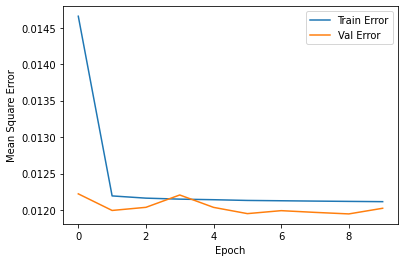

In [ ]:
def plot_history():
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error')
    plt.plot(hist['epoch'], hist['loss'], label='Train Error')
    plt.plot(hist['epoch'], hist['val_loss'], label = 'Val Error')
    plt.legend()

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

plot_history()

So epoch = 5 works here. Other hyperparameters to tune later: 


*   Number of hidden layers
*   Number of nodes in each layer
*   Activation
*   Optimizer
*   Learning rate
*   Batch size